# CNN for Classification of Small Images (CIFAR 10 dataset)

This notebook is an adaptation of a demo notebook in the Pytorch documentation. Please be patient while running the code in the notebook. 

We haven't used a GPU \(that might be available on your computer\) and training two epochs on CPU takes around a minute.

In order to run the code you need to install pytorch on your system. The modules `torch` and `torchvision` should be installed. See the [PyTorch](https://pytorch.org/) website how to install Pytorch on your machine.

*Important*: We recommend installing torch version <= 1.13.1.

The [PyTorch](https://pytorch.org/) website is invaluable for understanding the code in this notebook. And it is a great source for further exploration of modern Machine Learning.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = None; 
# device = torch.device('cpu') # uncomment this line to explicitly set the device
if device == None:
    if torch.cuda.is_available():
        print("CUDA used")
        device = torch.device('cuda')
    else:
        print("CPU used")
        device = torch.device('cpu')

CPU used


## Loading Images from the Data Set

PyTorch includes several built-in datasets, including CIFAR. The provided code downloads and load this dataset, transforming the images during training and testing. Specifically, it converts images to tensors (PyTorch's fundamental data structure, similar to NumPy's ndarray) and normalizes them by subtracting 0.5 from each RGB value and dividing by 0.5. This shifts the RGB values from a range of 0-1 to -1 to +1, which is crucial for neural network performance.

PyTorch loads a dataset into separate train and test sets. First we define the trainset.

In [3]:
# Uncomment the following 2 lines if you get a SSL certificate error to disable the verification.
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context (edited)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


The trainset has an attribute ``data`` that contains the entire datamatrix in a numpy array.

In [4]:
trainset.data.shape

(50000, 32, 32, 3)

i.e. 50000 images of 32x32 pixels each with an R, G and B value.

Also the labels are encoded in a simple Python list

In [5]:
len(trainset.targets)

50000

The target values are indices from 0 to 9 and the corresponding class names are encoded in the following list:

In [6]:
classnames = trainset.classes
print(classnames)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In pure Python/Numpy we can now display one of the images with the target class name as title for the plot:

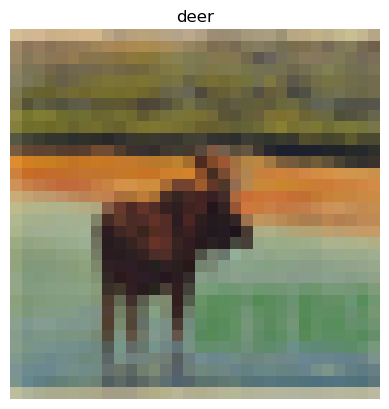

In [7]:
i = 66
plt.imshow(trainset.data[i])
plt.axis('off')
plt.title(classnames[trainset.targets[i]]);

Later on we will define a ``DataLoader`` that makes it easy to load a small number of (image, target) tuples (a batch) needed in one gradient descent step in the stochastic gradient learning process. While loading the data the data in the dataset is transformed on the fly. For this dataset two transforms are used in sequence. First the ``ToTensor`` transform that takes an HxWxC (with C=3) numpy array into a PyTorch tensor of shape CxHxW which is the standard for encoding color images in deep learning. The second transform in the sequence is a normalization (see the PyTorch documentation for ``torchvision.transforms.Normalize``).

Later, we will create a `DataLoader` to facilitate the loading of small batches of (image, target) tuples required for each step of stochastic gradient descent. This DataLoader will perform on-the-fly transformations on the dataset. For this dataset, two sequential transformations are applied: `ToTensor`, which converts an HxWxC (where C=3) NumPy array into a PyTorch tensor in the CxHxW format (standard for color images in deep learning), and normalization, as specified in the PyTorch documentation for `torchvision.transforms.Normalize`.

<span style="color:red">**Question 1.1**</span>

Given the normalization ``Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`` and an original color value (r,g,b) what is the normalized color value (r',g',b')? Why do we have 6 0.5s?

YOUR ANSWER HERE\
After normalizing the range shifts to -1 to +1. The Normalize takes the (mean, std) as inputs. in a range between 0-1, the mean and std are the same: 0.5.

In the same way we define and load the testset:

In [8]:
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

We will define a `DataLoader` for both the training and testing sets. In the DataLoader's constructor, specify the batch_size. This DataLoader, functioning as a Python iterable, enables the retrieval of `batch_size` arbitrary images from the dataset.

In [9]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

## Displaying Tensor Images

For displaying 'tensor images' we provide two helper functions:

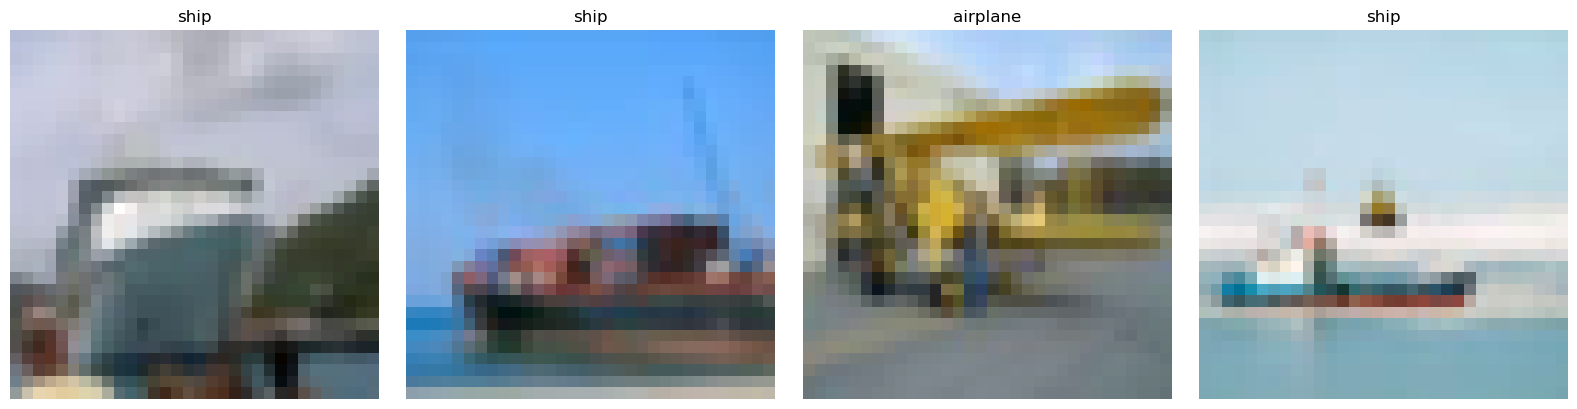

In [10]:
def imshow(img, ax=None):
    """imshow for Tensor Images obtained with a DataLoader
    from a data set. The images are of shape (3,M,N)
    and are in the range from -1 to +1"""
    img = (img - img.min()) / (img.max()-img.min())     # unnormalize
    npimg = img.numpy()
    if ax==None:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        
def imtable(imgs, titles, ncols, hsize=4, vsize=4):
    nrows = int(np.ceil(len(imgs)/ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*hsize, nrows*vsize))
    r, c = 0, 0
    for i, (im, label) in enumerate(zip(imgs, titles)):
        if nrows==1:
            ax = axs[c]
        elif ncols==1:
            ax = axs[r]
        else:
            ax = axs[r,c]
        imshow(im, ax=ax)
        ax.set_title(titles[i])
        ax.axis('off')
        c += 1
        if c == ncols:
            r += 1
            c = 0
    plt.tight_layout()
        
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
imtable(images, [classnames[i] for i in labels], 4)


<span style="color:red">**Question 1.2**</span>

If you would be random guessing the class of an image what would be the expected accuracy of the 'classifier'?

YOUR ANSWER HERE\
The expected accuracy is 10 percent. Because the database has 10 different classes. The probablity for each class is 1/10

## Define a Convolutional Neural Network


We define a CNN to classify CIFAR images by first instantiating the functional processing blocks in the `__init__` function and then utilizing them in the `forward` method to implement the network's forward pass from input to output.

PyTorch automatically handles the backpropagation to calculate derivatives of the loss with respect to the data throughout the network. However, if you introduce new functional processing blocks as a programmer, you will need to manually implement the backward pass.

In [11]:
class Net(nn.Module):
    def __init__(self, verbose=0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.verbose = verbose
        
    def forward(self, x):
        # Note in the forward pass we have 'numbered'
        # the x's just to make it easier to collect
        # the code to print information about the network
        # further on in the code.

        # This is very bad code!!

        conv1_out = self.conv1(x)
        if self.verbose == 1:
            print("Shape of conv1(x):", conv1_out.shape)
        x1 = self.pool1(F.relu(self.conv1(x)))
        if self.verbose == 1:
            print(f"Shape x1: {x1.shape}")
        x2 = self.pool2(F.relu(self.conv2(x1)))
        if self.verbose == 1:
            print(f"Shape x2: {x2.shape}")
        x3 = torch.flatten(x2, 1) # flatten all dimensions except batch
        if self.verbose == 1:
            print(f"Shape x3: {x3.shape}")
        x4 = F.relu(self.fc1(x3))
        if self.verbose == 1:
            print(f"Shape x4: {x4.shape}")
        x5 = F.relu(self.fc2(x4))
        if self.verbose == 1:
            print(f"Shape x5: {x5.shape}")
        x6 = self.fc3(x5)
        if self.verbose == 1:
            print(f"Shape x6: {x6.shape}")
        self.conv1 = nn.Conv2d(3, 10, 5)
        if self.verbose == 1:
            print(self.conv1)

        if self.verbose == 1:
            # Write the code to print the shapes of the 
            # different stages in the CNN
            # YOUR CODE HERE (Replace this and the following line with your code)
            self.verbose -= 1
        
        return x6

# with verbose=1 the 'debugging' code is printed only once 
# while running the forward pass multiple times.
net = Net(verbose=0).to(device=device)

When you print an instance of a network class, it provides an overview of the functional processing blocks defined within. Note that functions like `relu` and `flatten` won't appear in this printout, although they are part of the processing flow. The reason for this is that we define these 'activation' and 'flattening' functions as part of the forward pass, utilizing `functional` block, and not `nn.Module` representing operation (see [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) and [torch.nn.functional.relu
](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html), and [this thread](https://discuss.pytorch.org/t/f-relu-and-nn-relu/123071/2) to understand the difference).

In [12]:
print(net)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)



When you instantiate the `Net` class and print it, the output does not show the shapes of data processed at each layer. To address this, you can modify the `Net` class to include detailed information about the data shapes.

The example code sets the `verbose` attribute of the `Net` instance to 1 and feeds it a batch of images. While the output is printed, it’s important to remember that it doesn't represent meaningful data yet as the network hasn't learned anything.

PyTorch automatically handles the initialization of parameters for each processing module in the network. However, you can customize this initialization if desired by referring to the PyTorch documentation.

In [13]:
net.verbose=1 # when you run it you should set this to 1
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
outputs = net(images)
print(outputs)

Shape of conv1(x): torch.Size([4, 10, 28, 28])
Shape x1: torch.Size([4, 10, 14, 14])
Shape x2: torch.Size([4, 16, 5, 5])
Shape x3: torch.Size([4, 400])
Shape x4: torch.Size([4, 120])
Shape x5: torch.Size([4, 84])
Shape x6: torch.Size([4, 10])
Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
tensor([[-0.1181, -0.0525,  0.0119, -0.0474, -0.0450,  0.0336,  0.0735, -0.0862,
         -0.0229, -0.0993],
        [-0.1317, -0.0487,  0.0318, -0.0410, -0.0477,  0.0438,  0.0615, -0.0867,
         -0.0421, -0.1039],
        [-0.1211, -0.0577,  0.0082, -0.0432, -0.0433,  0.0396,  0.0795, -0.0830,
         -0.0347, -0.0911],
        [-0.1194, -0.0524,  0.0202, -0.0476, -0.0450,  0.0322,  0.0796, -0.0759,
         -0.0317, -0.0909]], grad_fn=<AddmmBackward0>)


With the printed information you ought to be able to answer the following questions:

In a data graph the first part of this network looks like
<img src="cifar_cnn_incomplete.png"
     width=80%
     alt="data flow graph"
     style="float: center;" />

In a typical CNN representation, the **data blocks** are depicted as the dimensions of the data at each stage, with **arrows** representing the processing modules. For instance, the first arrow might represent the sequence of operations: `Conv1 --> ReLU --> Maxpool`.

The CIFAR images start as 32x32 pixels with 3 color channels (RGB), denoted as $W_1 = H_1 = 32$ and $C_1 = 3$. At the end of the CNN, the output is a 10-element vector, where each element corresponds to the activation for one of the ten classes. This final layer is achieved through a fully connected network that maps from a previous layer, which is an 84-element vector.

To track changes in data shape after specific layers, such as after the first or second convolution, you would need to adjust the `forward` method in the network class. This modification can help with debugging or understanding how the network processes and transforms the input data through its layers.

<span style="color:red">**Question 2.1**</span>

If you print the shape of tensor ``x`` in the ``forward`` method you will get ``torch.Size([4, 3, 32, 32])``. Why is the first dimension of size 4 in this tensor? Note that this size is NOT depicted in the above graph!

YOUR ANSWER HERE\
The first element of the list is the batch size. Here it's 4 beacuse we want to take batches of 4 pictures from the database.

<span style="color:red">**Question 2.2**</span>

What is the shape of the output of ``conv1(x)``? What does it tell you about the convolution/correlation algorithm that is used? To find this experimentally you have to change the code in the ``forward`` method.

YOUR ANSWER HERE\
After changing the forward function the shape of conv1(x) is: torch.Size([4, 10, 28, 28]) the shrinking height and width indicate that convolution is used.

<span style="color:red">**Question 2.3**</span>

Complete the data graph. For each of data block (image blocks at the start and flattened arrays at the end) you should indicate the shape of the block. The blocks correspond with the tensors `x`, `x1` ... `x6` in the `forward` method. Either you should look into the documentation of the processing modules that are being used in the `__init__` function or you should run the code and print the shapes (when we are running/training the network).

YOUR ANSWER HERE
after changing the documentation and printing the shapes the shapes are:
Shape x1: torch.Size([4, 10, 14, 14])
Shape x2: torch.Size([4, 16, 5, 5])
Shape x3: torch.Size([4, 400])
Shape x4: torch.Size([4, 120])
Shape x5: torch.Size([4, 84])
Shape x6: torch.Size([4, 10])

<span style="color:red">**Question 2.4**</span>

In the `__init__` function the following processing modules are defined: `conv1`, `pool1`, `conv2`, `pool2`, `fc1`, `fc2` and `fc3`. Indicate where these modules are used in your data flow graph (i.e. you have to label the arrows in the graph with the (sequence of) operations associated with each arrow.

YOUR ANSWER HERE\
Vanuit de input laag naar naar de eerstvolgende laag (pijl 1 / fc1 -> fc2) is de sequence of operations: conv1 -> pool1. Daarna heeft pijl 2 (fc2 -> fc3) de sequence: conv2 -> pool2 -> fc3.\
Of in totaal: fc1 -> conv1 -> pool1 -> fc2 -> conv2 -> pool2 -> fc3.

<span style="color:red">**Question 2.5**</span>

For each of processing modules `conv1`, `pool1`, `conv2`, `pool2`, `fc1`, `fc2` and `fc3` give the number of parameters that have to be learned (don't forget the bias parameters...)

YOUR ANSWER HERE\
Om te beginnen hebben pooling layers geen trainbare parameters, dus die zal ik ook niet bespreken\
fc1: (120 x 400) + 120 = 48.120\
fc2: (84 x 120) + 84 = 10.164\
fc3: (10 x 84) + 10 = 850\
conv1: (10 x 3 x 5 x 5) + 10 = 760\
conv2: (16 x 10 x 5 x 5) + 16 = 4.016\
Geeft een totaal van 63.910 trainbare parameters.

**HINT**: The answer to question 2.5 can be computed by 'interrogating' the network. For instance for the `fc2` linear module we get:

In [14]:
for p in net.conv2.parameters():
    print(p.shape)

torch.Size([16, 10, 5, 5])
torch.Size([16])


So for this module there are two tensors defining the parameters. Note that an object of type `torch.Size` is not a tensor

<span style="color:red">**Question 2.6**</span>

What are these tensors? (please look back in your machine learning course notes).

YOUR ANSWER HERE\
A tensor is a multi-dimensional array that in machine learning efficiently represent data and model parameters for computation for CPUs or GPUs.

<span style="color:red">**Question 2.7**</span>

How many parameters in total for this `fc2` module?

YOUR ANSWER HERE\
10.164

Below you have to write the code to calculate the total number of parameters to be learned in this network.

In [15]:
# Write the code to calculate the total number of parameters in the entire network
# YOUR CODE HERE (Replace this and the following line with your code)
total_params = 0
for p, name in zip(net.parameters(), ['conv1 weights', 'conv1 bias', 'conv2 weights', 'conv2 bias', 'fc1 weights', 'fc1 bias', 'fc2 weights', 'fc2 bias', 'fc3 weights', 'fc3 bias']):
    print(f'{name}: {p.shape} = {p.numel()}')
    total_params += p.numel()
print("Total number of parameters in the network:", total_params)

conv1 weights: torch.Size([10, 3, 5, 5]) = 750
conv1 bias: torch.Size([10]) = 10
conv2 weights: torch.Size([16, 10, 5, 5]) = 4000
conv2 bias: torch.Size([16]) = 16
fc1 weights: torch.Size([120, 400]) = 48000
fc1 bias: torch.Size([120]) = 120
fc2 weights: torch.Size([84, 120]) = 10080
fc2 bias: torch.Size([84]) = 84
fc3 weights: torch.Size([10, 84]) = 840
fc3 bias: torch.Size([10]) = 10
Total number of parameters in the network: 63910


Later on in this notebook we revisit the interrogation of the network again to actually observe what parameter values are learned.

## Loss Function and Optimizer

To train the network we also need to define a loss function:

In [16]:
loss_criterion = nn.CrossEntropyLoss()

When input data is processed through a neural network in PyTorch, the output is obtained with:

```python
outputs = net(inputs)
```

These outputs are then compared with the target values using the `CrossEntropyLoss` function. This loss function is particularly suited for classification tasks because it handles the softmax activation internally, which is why a separate softmax function is not required in this network.

It is important to note that while the network output is a 10-element vector representing the activation for each class, the target for each example is simply an integer representing the class ID. The conversion from this integer format to a _one-hot encoding_ is handled implicitly within the `CrossEntropyLoss` function, simplifying the input requirements for this function.

We also need an optimizer. A standard optimizer is PyTorch is the SGD (Stochastic Gradient Descent) optimizer.

In [17]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, dampening=0)

here `lr` is the learning rate. The momentum is used in the gradient descent procedure to 'remember' in which direction the gradient descent is running and not deviate too easily from that direction.

<span style="color:red">**Question 2.8**</span>

Read the explanation of the SGD optimizer in the PyTorch documentation.
1. Why the name **stochastic** gradient descent?
2. What value for the ``momemtum`` and `dampening` should be chosen to get the classical gradient descent?

YOUR ANSWER HERE\
Stochastic means that the optimizer estimates the gradient instead of calculating the gradient over the whole dataset at each step. The estemating introduces noise.\
To get classic gradient descent, the values should be zero.

## Training the Network

Training a neural network using a variant of the gradient descent algorithm typically involves the following steps:

1. **Feed a Mini-Batch**: Feed a mini-batch of examples into the network.
2. **Forward Pass**: Execute the forward pass, which calculates the output through all the network's intermediate processing modules.
3. **Zero Gradients**: Set all gradients to zero to prevent accumulation from previous iterations.
4. **Backward Pass**: Calculate the backward pass to determine all the gradients.
5. **Parameter Update**: Update each parameter by making a step in the direction that minimizes the loss.

This process is repeated for all mini-batches in the training set, completing what is known as an **epoch**. The training continues for a specified number of epochs.

During training, it's important to monitor the loss:
- **Training Loss**: Calculate and record the loss on the training set after each epoch.
- **Test Loss**: Similarly, calculate the loss on the test set to evaluate generalization.
- **Intermediate Monitoring**: To check progress within an epoch, report the loss for the last few batches.

The entire process for one epoch is encapsulated in the `train_loop` function, which handles these operations and tracks progress.


In [18]:
def train_loop(dataloader, model, loss_fn, optimizer, no_report=1000, device=None):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Move the data to GPU (if available)
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % no_report == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        

While learning for several epochs we also calculate the performance on the test or validation set. This is encoded in the function `test_loop`.

In [19]:
def test_loop(dataloader, model, loss_fn, device=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The learning process then becomes:

In [20]:
%%timeit -n1 -r1
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, net, loss_criterion, optimizer, device=device)
    test_loop(testloader, net, loss_criterion, device=device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.260852  [    0/50000]
loss: 2.292311  [ 4000/50000]
loss: 2.264485  [ 8000/50000]
loss: 2.311833  [12000/50000]
loss: 2.328743  [16000/50000]
loss: 2.399134  [20000/50000]
loss: 2.254781  [24000/50000]
loss: 2.291280  [28000/50000]
loss: 2.251230  [32000/50000]
loss: 2.450566  [36000/50000]
loss: 2.310879  [40000/50000]
loss: 2.423047  [44000/50000]
loss: 2.304096  [48000/50000]
Test Error: 
 Accuracy: 18.6%, Avg loss: 2.192839 

Epoch 2
-------------------------------
loss: 2.229520  [    0/50000]
loss: 2.230584  [ 4000/50000]
loss: 2.009138  [ 8000/50000]
loss: 2.044782  [12000/50000]
loss: 2.002610  [16000/50000]
loss: 1.952102  [20000/50000]
loss: 1.747257  [24000/50000]
loss: 2.499846  [28000/50000]
loss: 1.763695  [32000/50000]
loss: 2.188468  [36000/50000]
loss: 2.631223  [40000/50000]
loss: 1.463880  [44000/50000]
loss: 2.067712  [48000/50000]
Test Error: 
 Accuracy: 28.1%, Avg loss: 1.975714 

Done!
1min 48s ± 0 ns per loop (mean

In [21]:
# Uncomment the following 2 lines to save your network to file
# PATH = './cifar_net_100e.pth'
# torch.save(net.state_dict(), PATH)

# when saved you can load it back into memory with
# (again uncomment the following 2 lines)
# net = Net().to(device)
# net.load_state_dict(torch.load(PATH))

We load some images from the test set, display these image with their ground truth label. 

In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imtable(images, [classnames[i] for i in labels], 4)

AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute 'next'

Then we feed these to the network and print the outputs of the 10 output nodes for all images. Note that now we are not training the network, so torch doesn't need to keep track of all the intermediate outputs of all modules in the network (in preparation of a backward pass) and we can tell Pytorch not to do that with `no_grad()`.

During the training phase, the `softmax` function was not applied to the outputs of the network. This is because the `CrossEntropyLoss` function in PyTorch automatically includes softmax as part of its computation, and using an additional softmax layer before applying this loss function is not necessary and can lead to incorrect training results.

However, when using the network in feed-forward mode only (i.e., for inference and not training), it is appropriate to apply the `softmax` function to the outputs. This normalizes the outputs to produce a distribution of probabilities across the 10 classes, representing the model's predictions as a posteriori class probabilities:

In [23]:
with torch.no_grad():
    outputs = F.softmax(net(images.to(device)), dim=-1)
npoutputs = outputs.cpu().numpy()
print(npoutputs)

[[0.17115887 0.10935178 0.07656749 0.05435533 0.10161292 0.08026578
  0.01617444 0.20559044 0.1046323  0.08029062]
 [0.1415459  0.41484976 0.01179793 0.00971141 0.02468218 0.00740919
  0.00384781 0.01180584 0.21086945 0.16348055]
 [0.04747098 0.01228911 0.19191834 0.15603995 0.18090376 0.11475608
  0.16525981 0.07525932 0.0363613  0.01974124]
 [0.07188392 0.20569275 0.04209489 0.07738608 0.05358511 0.0690819
  0.04197348 0.13072686 0.08316759 0.22440737]]


The predicted label will be the label with the largest output value.

In [24]:
maxvalue, maxindex = torch.max(outputs, 1)
print('True     : ', ' '.join('%10s' % classnames[labels[j]]
                              for j in range(batch_size)))
print('Predicted: ', ' '.join('%10s' % classnames[maxindex[j]]
                              for j in range(batch_size)))

True     :       horse   airplane       bird      truck
Predicted:       horse automobile       bird      truck


For such a small set of test images we run into the possibility that the classification is very bad. Let's test the network more carefully.

## Inspecting the Network

Understanding the internal workings of a convolutional neural network (CNN) is often complex. Specifically, it can be challenging to determine what the learned weights represent, and many aspects of these networks remain largely unexplained. While there are several research papers that attempt to describe what specific nodes in a network respond to, these analyses are typically beyond the scope of an introductory course.

### Visualizing the First Layer in CNNs

An exception to this complexity is the visualization of the first layer in a CNN. The first layer's convolutional kernels directly interact with the input image data and can be visualized as images. In traditional computer vision, convolution kernels are used to detect specific features like edges, corners, and textures, and these can be similarly interpreted in CNNs.

The hypothesis behind CNNs is that local structures in images carry the spatial information necessary for image interpretation. By visualizing the kernels, we can see if the network has learned to detect various local structure patterns, such as edges and textures. These patterns are then combined in subsequent layers to recognize larger structures in images.

Your task is to visualize the kernels in the first convolution module `conv1` as small images.

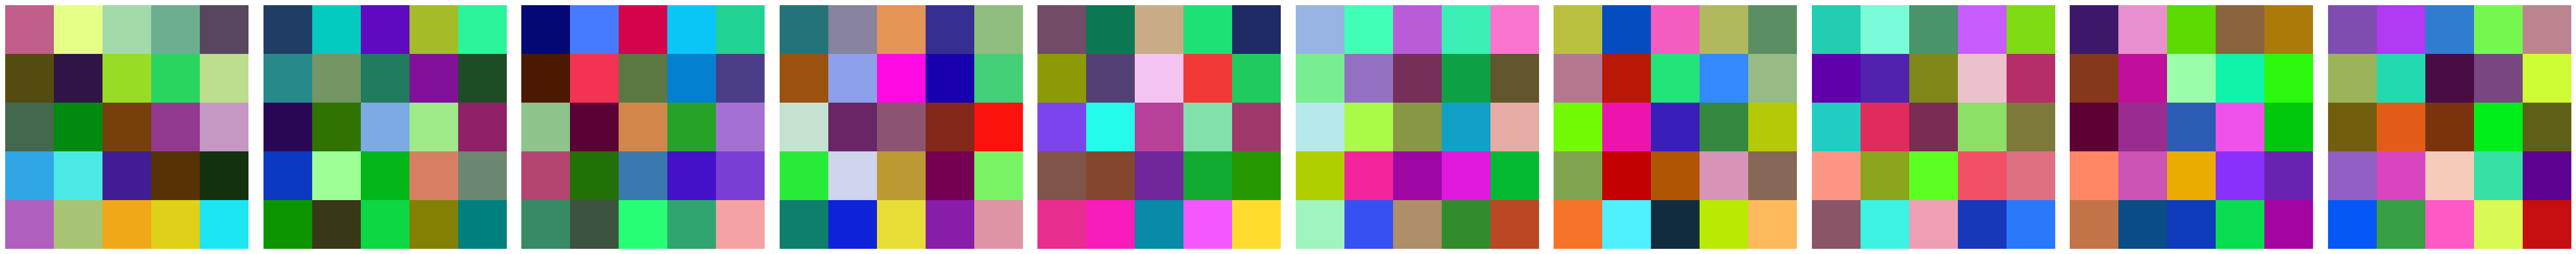

In [25]:
# Here the code to visualize the kernels
# YOUR CODE HERE (Replace this and the following line with your code)
def show_kernels(kernels, ncols, hsize, vsize):
    fig, axs = plt.subplots(1, ncols, figsize=(ncols*hsize, vsize))
    for i, kernel in enumerate(kernels):
        ax = axs[i]
        imshow(kernel, ax=ax)
        ax.axis('off')
    plt.tight_layout()
kernels = net.conv1.weight.data.cpu()
n_colls = kernels.shape[0]
h_size = kernels.shape[2]
v_size = kernels.shape[3]
show_kernels(kernels, ncols=n_colls, hsize=h_size, vsize=v_size)


## Improving the Network

Choosing the right architecture for a convolutional neural network (CNN) often involves more art than science. Unlike other engineering disciplines where decisions can be based on precise calculations or established theories, designing a CNN requires a more experimental approach.

The process of selecting and refining a CNN architecture typically involves a lot of trial and error. Developers/researchers might start with a basic model, test its performance, and then iteratively adjust the number of layers and channels to find the optimal configuration for their specific application. This experimental process allows for discovering how different configurations impact learning and performance, guiding the development towards the most effective model design.

In [26]:
%%timeit -n1 -r1
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, net, loss_criterion, optimizer, device=device)
    test_loop(testloader, net, loss_criterion, device=device)
print("Done!")

Epoch 1
-------------------------------
loss: 1.828965  [    0/50000]
loss: 1.544151  [ 4000/50000]
loss: 1.885576  [ 8000/50000]
loss: 1.514337  [12000/50000]
loss: 1.394904  [16000/50000]
loss: 1.525707  [20000/50000]
loss: 2.208327  [24000/50000]
loss: 1.933784  [28000/50000]
loss: 1.911335  [32000/50000]
loss: 2.184885  [36000/50000]
loss: 1.441190  [40000/50000]
loss: 2.348816  [44000/50000]
loss: 2.100231  [48000/50000]
Test Error: 
 Accuracy: 30.9%, Avg loss: 1.894000 

Epoch 2
-------------------------------
loss: 1.458751  [    0/50000]
loss: 2.025425  [ 4000/50000]
loss: 3.480224  [ 8000/50000]
loss: 1.459165  [12000/50000]
loss: 1.422562  [16000/50000]
loss: 1.998060  [20000/50000]
loss: 1.799861  [24000/50000]
loss: 2.073916  [28000/50000]
loss: 2.028346  [32000/50000]
loss: 2.856667  [36000/50000]
loss: 1.754584  [40000/50000]
loss: 2.111237  [44000/50000]
loss: 1.897576  [48000/50000]
Test Error: 
 Accuracy: 33.0%, Avg loss: 1.844186 

Epoch 3
----------------------------

In [27]:
PATH = './cifar_net_100e_epoch-10.pth'
torch.save(net.state_dict(), PATH)

In [36]:
class Net(nn.Module):
    def __init__(self, verbose=0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.verbose = verbose
        
    def forward(self, x):
        # Note in the forward pass we have 'numbered'
        # the x's just to make it easier to collect
        # the code to print information about the network
        # further on in the code.

        # This is very bad code!!

        conv1_out = self.conv1(x)
        if self.verbose == 1:
            print("Shape of conv1(x):", conv1_out.shape)
        x1 = self.pool1(F.relu(self.conv1(x)))
        if self.verbose == 1:
            print(f"Shape x1: {x1.shape}")
        x2 = self.pool2(F.relu(self.conv2(x1)))
        if self.verbose == 1:
            print(f"Shape x2: {x2.shape}")
        x3 = torch.flatten(x2, 1) # flatten all dimensions except batch
        if self.verbose == 1:
            print(f"Shape x3: {x3.shape}")
        x4 = F.relu(self.fc1(x3))
        if self.verbose == 1:
            print(f"Shape x4: {x4.shape}")
        x5 = F.relu(self.fc2(x4))
        if self.verbose == 1:
            print(f"Shape x5: {x5.shape}")
        x6 = self.fc3(x5)
        if self.verbose == 1:
            print(f"Shape x6: {x6.shape}")
        self.conv1 = nn.Conv2d(3, 20, 5)
        if self.verbose == 1:
            print(self.conv1)

        if self.verbose == 1:
            # Write the code to print the shapes of the 
            # different stages in the CNN
            # YOUR CODE HERE (Replace this and the following line with your code)
            self.verbose -= 1
        
        return x6

# with verbose=1 the 'debugging' code is printed only once 
# while running the forward pass multiple times.
net = Net(verbose=0).to(device=device)

In [37]:
%%timeit -n1 -r1
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, net, loss_criterion, optimizer, device=device)
    test_loop(testloader, net, loss_criterion, device=device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305791  [    0/50000]
loss: 2.303194  [ 4000/50000]
loss: 2.304226  [ 8000/50000]
loss: 2.339684  [12000/50000]
loss: 2.274350  [16000/50000]
loss: 2.363783  [20000/50000]
loss: 2.315879  [24000/50000]
loss: 2.347579  [28000/50000]
loss: 2.317857  [32000/50000]
loss: 2.286231  [36000/50000]
loss: 2.254052  [40000/50000]
loss: 2.361178  [44000/50000]
loss: 2.363640  [48000/50000]
Test Error: 
 Accuracy: 9.7%, Avg loss: 2.306136 

Epoch 2
-------------------------------
loss: 2.309299  [    0/50000]
loss: 2.341513  [ 4000/50000]
loss: 2.343765  [ 8000/50000]
loss: 2.350560  [12000/50000]
loss: 2.346117  [16000/50000]
loss: 2.336022  [20000/50000]
loss: 2.326306  [24000/50000]
loss: 2.360272  [28000/50000]
loss: 2.319454  [32000/50000]
loss: 2.292853  [36000/50000]
loss: 2.297202  [40000/50000]
loss: 2.312392  [44000/50000]
loss: 2.386729  [48000/50000]
Test Error: 
 Accuracy: 9.6%, Avg loss: 2.306272 

Done!
2min 25s ± 0 ns per loop (mean ±

In [38]:
PATH = './cifar_net_100e_channels-20.pth'
torch.save(net.state_dict(), PATH)

In [40]:
class Net(nn.Module):
    def __init__(self, verbose=0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.verbose = verbose
        
    def forward(self, x):
        # Note in the forward pass we have 'numbered'
        # the x's just to make it easier to collect
        # the code to print information about the network
        # further on in the code.

        # This is very bad code!!

        conv1_out = self.conv1(x)
        if self.verbose == 1:
            print("Shape of conv1(x):", conv1_out.shape)
        x1 = self.pool1(F.relu(self.conv1(x)))
        if self.verbose == 1:
            print(f"Shape x1: {x1.shape}")
        x2 = self.pool2(F.relu(self.conv2(x1)))
        if self.verbose == 1:
            print(f"Shape x2: {x2.shape}")
        x3 = torch.flatten(x2, 1) # flatten all dimensions except batch
        if self.verbose == 1:
            print(f"Shape x3: {x3.shape}")
        x4 = F.relu(self.fc1(x3))
        if self.verbose == 1:
            print(f"Shape x4: {x4.shape}")
        x5 = F.relu(self.fc2(x4))
        if self.verbose == 1:
            print(f"Shape x5: {x5.shape}")
        x6 = self.fc3(x5)
        if self.verbose == 1:
            print(f"Shape x6: {x6.shape}")
        self.conv1 = nn.Conv2d(3, 10, 3)
        if self.verbose == 1:
            print(self.conv1)

        if self.verbose == 1:
            # Write the code to print the shapes of the 
            # different stages in the CNN
            # YOUR CODE HERE (Replace this and the following line with your code)
            self.verbose -= 1
        
        return x6

# with verbose=1 the 'debugging' code is printed only once 
# while running the forward pass multiple times.
net = Net(verbose=0).to(device=device)

In [41]:
%%timeit -n1 -r1
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, net, loss_criterion, optimizer, device=device)
    test_loop(testloader, net, loss_criterion, device=device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.321242  [    0/50000]
loss: 2.314733  [ 4000/50000]
loss: 2.294039  [ 8000/50000]
loss: 2.299148  [12000/50000]
loss: 2.282657  [16000/50000]
loss: 2.268319  [20000/50000]
loss: 2.298590  [24000/50000]
loss: 2.310515  [28000/50000]
loss: 2.302305  [32000/50000]
loss: 2.318096  [36000/50000]
loss: 2.338607  [40000/50000]
loss: 2.353184  [44000/50000]
loss: 2.293826  [48000/50000]
Test Error: 
 Accuracy: 10.2%, Avg loss: 2.304593 

Epoch 2
-------------------------------
loss: 2.324961  [    0/50000]
loss: 2.281525  [ 4000/50000]
loss: 2.328876  [ 8000/50000]
loss: 2.313206  [12000/50000]
loss: 2.313349  [16000/50000]
loss: 2.310118  [20000/50000]
loss: 2.332137  [24000/50000]
loss: 2.361635  [28000/50000]
loss: 2.318473  [32000/50000]
loss: 2.288047  [36000/50000]
loss: 2.266265  [40000/50000]
loss: 2.310232  [44000/50000]
loss: 2.313505  [48000/50000]
Test Error: 
 Accuracy: 10.2%, Avg loss: 2.304529 

Done!
2min 4s ± 0 ns per loop (mean 

In [ ]:
PATH = './cifar_net_100e_kernel-3.pth'
torch.save(net.state_dict(), PATH)

<span style="color:red">**Question 5.1**</span>

1. The obvious way to start improving your network is by training for more epochs. Only 2 epochs is really not much (but you need a fast computer or a GPU or a lot of patience). But you should be able to increase the number of epochs from 2 to 10 when you run the learning at night. What do you observe?

1. Change the number of channels in the first data (image) block after the input image (a block with 3 channels) from 10 to 20 and train and run the network again. Does it improve the performance? Again start with 2 epochs of learning.

1. Change the size of the convolution kernels in the `conv1` module from 5 to 3. Again start with 2 epochs of learning. What happens to the shapes of all blocks in the network?

REPORT YOUR RESULTS HERE

## Bonus Exercise

When you can learn faster or have a faster machine or have more time you could learn for a lot of epochs (say 100) and then plot the loss and accuracy for both the train and test set as a function of the number of epochs. That may provide you with evidence that the network is overfitting and thus that some regularization techniques might be needed. This is suggested by the webpages describing learning for the same dataset but then implemented in Keras/Tensorflow (see https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/). There the loss and accuracy as function of the number of epochs is shown as (in yellow the testset scores and in blue the trainset scores):
<img src="cifar_overfitting.png"
     width=50%
     alt="data flow graph"
     style="float: center;" />
     
The network used was very much like the one that has been used in this lab.

- In the above mentioned paper, using `DropOut` the problem of overfitting was succesfully mitigated. Try to implement such DropOut using pytorch to mitigate the problem of overfitting.